In [1]:
import pandas as pd
import numpy as np 
import json
import os
import re
from gensim.parsing.preprocessing import strip_multiple_whitespaces

import matplotlib.pyplot as plt
import seaborn as sns

cameo_to_penta = {
    "Make Public Statement" : "Make a statement",
    "Appeal" : "Verbal Cooperation",  	#Statement?
    "Express Intend to Cooperate" : "Verbal Cooperation",
    "Consult" : "Verbal Cooperation",
    "Engage In Diplomatic Cooperation" : "Verbal Cooperation",
    "Engage In Material Cooperation" : "Material Cooperation",
    "Provide Aid" : "Material Cooperation",
    "Yield" : "Material Cooperation",  #Verbal?
    "Investigate" : "Material Conflict",
    "Demand" : "Verbal Conflict",
    "Disapprove" : "Verbal Conflict",
    "Reject" : "Verbal Conflict",
    "Threaten" : "Verbal Conflict",
    "Exhibit Military Posture" : "Material Conflict",
    "Protest" : "Verbal Conflict", #Material?
    "Reduce Relations" : "Verbal Conflict",
    "Coerce" : "Material Conflict",
    "Assault" : "Material Conflict",
    "Fight" : "Material Conflict",
    "Engage in unconventional mass violence" : "Material Conflict"
}

In [2]:
os.chdir("..")
#for pretrain data
data = pd.read_csv("soft_data/data/out_data/softdata_concat_noents.csv", index_col = 0)
data.shape

(24674, 2)

In [3]:
#check for duplicated inputs
data.text.duplicated().any()

False

In [4]:
#example lines
data.head()

,text,label
0,This is a worrying sign because it's different...,<triplet> Shivshankar Menon <subj> interviewer...
1,Indian students have flocked to Chinese univer...,<triplet> Indian students <subj> Chinese unive...
2,Actress Salma Hayek has also used Actress Salm...,<triplet> Actress Salma Hayek <subj> Actress S...
3,"a soldier's sister, Mayra, told NBC that Ms Gu...",<triplet> NBC <subj> Ms Guillen's sister <obj>...
4,When BBC Gujarati's Roxy Gadgekar's sister She...,<triplet> BBC Gujarati's Roxy Gadgekar <subj> ...


In [5]:
#num of original sentences

# General EDA

<AxesSubplot: xlabel='text_len'>

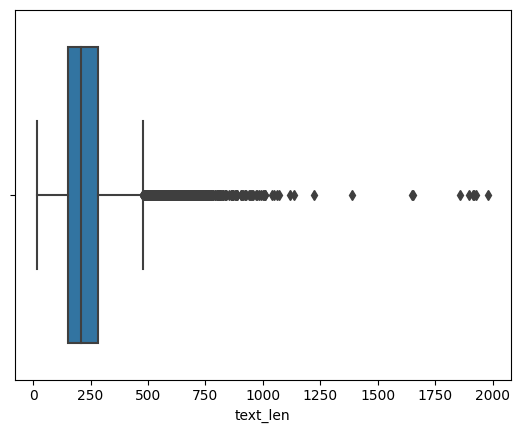

In [6]:
data["text_len"] = data.text.apply(lambda x: len(x))
sns.boxplot(x = data.text_len)

#there is an unsreasonable amount of data with very long texts.
#this might be a problem, since most text are sentences.
#500 seems like a reasonable cut-off to have data more uniform

In [7]:
data = data[data.text_len < 500]
data.shape

(24033, 3)

In [8]:
#How many relations does each text have?
data["rel_count"] = data.label.apply(lambda x: x.count("<triplet>"))
for count in range(data.rel_count.max()):
    print(f"Count of sentences with {count + 1} relations: {data[data.rel_count == count + 1].shape[0]}")

#all sentences have only 1 relation

Count of sentences with 1 relations: 23352
Count of sentences with 2 relations: 659
Count of sentences with 3 relations: 22


# EDA with CAMEO codes

In [9]:
#extract the categorized relation
data["label"] = data.label.apply(lambda x: strip_multiple_whitespaces(x.replace("<triplet>"," <triplet> ")))
relation = []
for row in data.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <subj> | <triplet>)", rel_iter)
    relation.append(all_rels)
data["relations"] = relation 

Text(0.5, 0, 'Label')

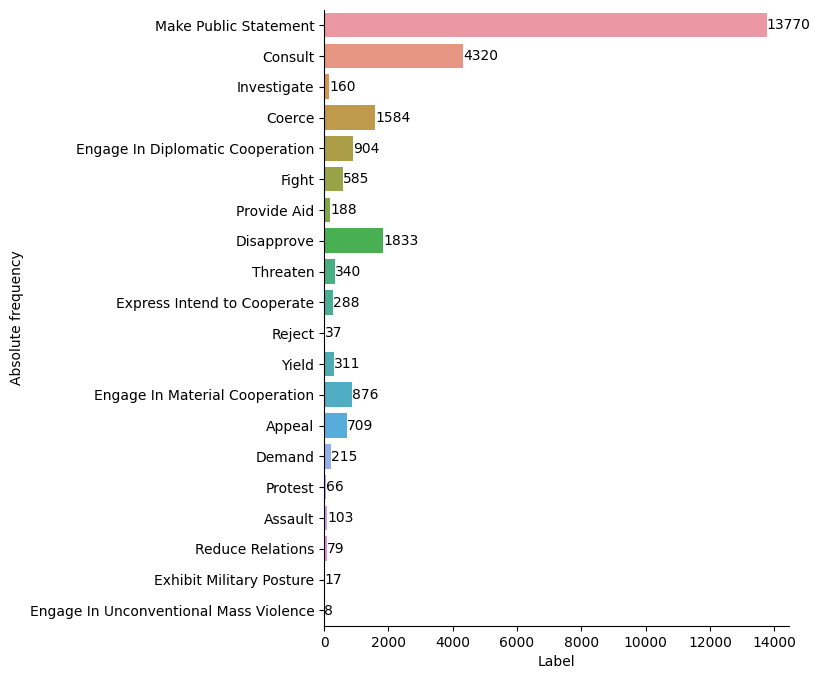

In [10]:
expl = data.explode("relations")
plt.figure(figsize=(6,8))
ax = sns.countplot(y = expl.relations)
ax.bar_label(ax.containers[0])
sns.despine()
plt.ylabel('Absolute frequency')
plt.xlabel('Label')

In [11]:
#address class imbalance with downsampling 
data["mps"] = data.label.apply(lambda x: "Make Public Statement" in x)
data["consult"] = data.label.apply(lambda x: "Consult" in x)

#data without consult or mps labels
data_1 = data[(data.mps == False) & (data.consult == False)]

#only mps / cons
data_mps = data[data.mps == True]
data_cons = data[data.consult == True]

#sort mps and cons data to prefer data with more relations to reduce removing of other labels than these two
data_mps["count_rels"] = data_mps.relations.apply(lambda x: len(x))
data_cons["count_rels"] = data_cons.relations.apply(lambda x: len(x))

data_mps.sort_values("count_rels", ascending = False, inplace = True)
data_cons.sort_values("count_rels", ascending = False, inplace = True)

#reduce to next best length (being disapprove)
data_new = pd.concat([data_1,data_mps.sample(n = 2700),data_cons.sample(n = 2700)])

/tmp/ipykernel_97999/2793995320.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mps["count_rels"] = data_mps.relations.apply(lambda x: len(x))
/tmp/ipykernel_97999/2793995320.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cons["count_rels"] = data_cons.relations.apply(lambda x: len(x))
/tmp/ipykernel_97999/2793995320.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

Text(0.5, 0, 'Label')

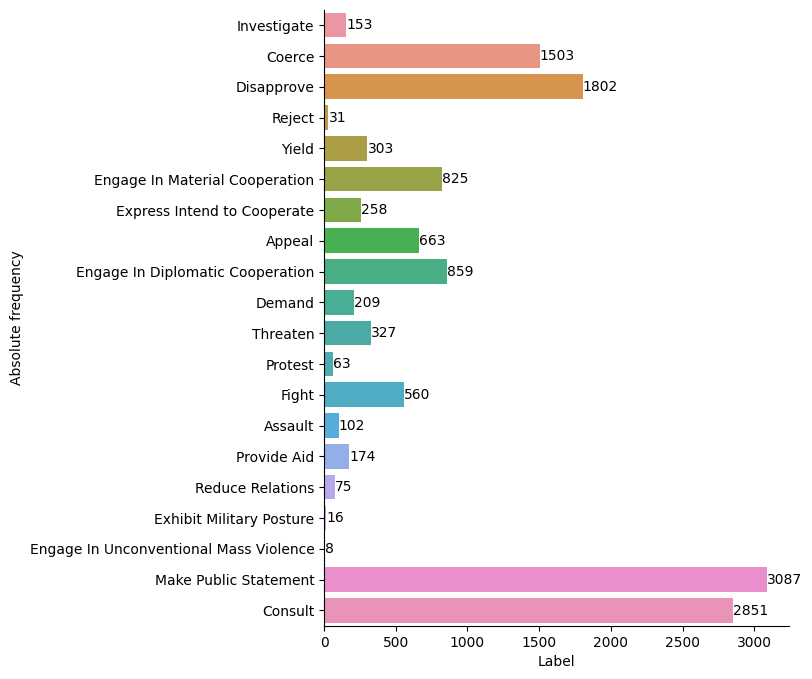

In [12]:
expl_new = data_new.explode("relations")
plt.figure(figsize=(6,8))
ax = sns.countplot(y = expl_new.relations)
ax.bar_label(ax.containers[0])
sns.despine()
plt.ylabel('Absolute frequency')
plt.xlabel('Label')

In [13]:

idx = []
for row in data_new.iterrows():
    if "Engage In Unconventional Mass Violence" in row[1]["relations"]: idx.append(row[0])
    #elif "Reject" in row[1]["relations"]: idx.append(row[0])
    #elif "Exhibit Military Posture" in row[1]["relations"]: idx.append(row[0])
#Drop unconventional mass violence because not represented 
data_rdy = data_new.drop(index = idx).reset_index().drop(columns = ["index"])

Text(0.5, 0, 'Label')

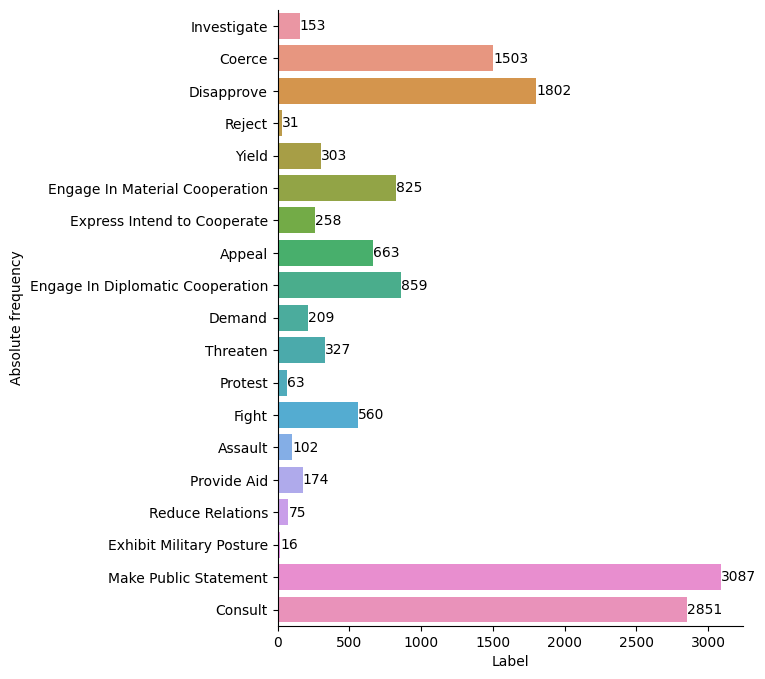

In [14]:
expl_3 = data_rdy.explode("relations")
plt.figure(figsize=(6,8))
ax = sns.countplot(y = expl_3.relations)
ax.bar_label(ax.containers[0])
sns.despine()
plt.ylabel('Absolute frequency')
plt.xlabel('Label')

In [15]:
data_rdy[["text","label"]].to_csv("data_src/unsupervised_data_preprocessed.csv")

In [68]:
## Maybe use this at some point. Generally oversampling makes the learning to free for these tasks
#upsampling of relations with less than 500 relations
data_new["inv"] = data_new.label.apply(lambda x: "Investigate" in x)
data_new["yield"] = data_new.label.apply(lambda x: "Yield" in x)
data_new["intend"] = data_new.label.apply(lambda x: "Express Intend to Cooperate" in x)
data_new["demand"] = data_new.label.apply(lambda x: "Demand" in x)
data_new["threat"] = data_new.label.apply(lambda x: "Threaten" in x)
data_new["protest"] = data_new.label.apply(lambda x: "Protest" in x)
data_new["assault"] = data_new.label.apply(lambda x: "Assault" in x)
data_new["aid"] = data_new.label.apply(lambda x: "Provide Aid" in x)
data_new["red"] = data_new.label.apply(lambda x: "Reduce Relations" in x)

#data where none of the relations are present
data2 = data_new[(data_new.inv == False) & 
                (data_new["yield"] == False) &
                (data_new.intend == False) &
                (data_new.demand == False) &
                (data_new.threat == False) &
                (data_new.protest == False) &
                (data_new.assault == False) &
                (data_new.aid == False) &
                (data_new.red == False)]

#only mps / cons
data_inv = data_new[(data_new.inv == True)]
data_yield = data_new[(data_new["yield"] == True)]
data_intend = data_new[(data_new.intend == True)]
data_demand = data_new[(data_new.demand == True)]
data_threat = data_new[(data_new.threat == True)]
data_protest = data_new[(data_new.protest == True)]
data_assault = data_new[(data_new.assault == True)]
data_aid = data_new[(data_new.aid == True)]
data_red = data_new[(data_new.red == True)]


#sort mps and cons data to prefer data with more relations to reduce removing of other labels than these two
data_inv["count_rels"] = data_inv.relations.apply(lambda x: len(x))
data_yield["count_rels"] = data_yield.relations.apply(lambda x: len(x))
data_intend["count_rels"] = data_intend.relations.apply(lambda x: len(x))
data_demand["count_rels"] = data_demand.relations.apply(lambda x: len(x))
data_threat["count_rels"] = data_threat.relations.apply(lambda x: len(x))
data_protest["count_rels"] = data_protest.relations.apply(lambda x: len(x))
data_assault["count_rels"] = data_assault.relations.apply(lambda x: len(x))
data_aid["count_rels"] = data_aid.relations.apply(lambda x: len(x))
data_red["count_rels"] = data_red.relations.apply(lambda x: len(x))

data_inv.sort_values("count_rels", ascending = True, inplace = True)
data_yield.sort_values("count_rels", ascending = True, inplace = True)
data_intend.sort_values("count_rels", ascending = True, inplace = True)
data_demand.sort_values("count_rels", ascending = True, inplace = True)
data_threat.sort_values("count_rels", ascending = True, inplace = True)
data_protest.sort_values("count_rels", ascending = True, inplace = True)
data_assault.sort_values("count_rels", ascending = True, inplace = True)
data_aid.sort_values("count_rels", ascending = True, inplace = True)
data_red.sort_values("count_rels", ascending = True, inplace = True)

#reduce to next best length (being disapprove)
#data_new = pd.concat([data_1,data_mps.sample(n = 2700),data_cons.sample(n = 2700)])


/tmp/ipykernel_2731093/2007985130.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_inv["count_rels"] = data_inv.relations.apply(lambda x: len(x))
/tmp/ipykernel_2731093/2007985130.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_yield["count_rels"] = data_yield.relations.apply(lambda x: len(x))
/tmp/ipykernel_2731093/2007985130.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [69]:
data_red

,text,label,text_len,rel_count,relations,mps,consult,count_rels,inv,yield,intend,demand,threat,protest,assault,aid,red
1554,"You know, it’s a feeling of guilt because Dr N...",<triplet> Dr Nokukhanya Khanyile’m <subj> Dr ...,100,1,[Reduce Relations],False,False,1,False,False,False,False,False,False,False,False,True
13003,MEC Maile rescinded MEC Maile's decision to su...,<triplet> MEC Maile <subj> MEC Maile's decisi...,79,1,[Reduce Relations],False,False,1,False,False,False,False,False,False,False,False,True
13051,"In recent months, One of the most prominent Pa...",<triplet> the Palestinian leadership <subj> t...,310,1,[Reduce Relations],False,False,1,False,False,False,False,False,False,False,False,True
14320,The Nobel Peace Prize winner who sent The Nobe...,<triplet> Ethiopia's troops <subj> the Africa...,360,1,[Reduce Relations],False,False,1,False,False,False,False,False,False,False,False,True
14579,"""President Donald Trump thereby betrayed Presi...",<triplet> President Donald Trump <subj> Presi...,222,1,[Reduce Relations],False,False,1,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1748,NATO has said NATO does not want direct confli...,<triplet> U. S. President Joe Biden <subj> U....,287,1,"[Reduce Relations, Reduce Relations]",False,False,2,False,False,False,False,False,False,False,False,True
17046,former taoiseach Bertie Ahern resigned from Fi...,<triplet> Fianna Fáil <subj> former taoiseach...,173,1,"[Reduce Relations, Reduce Relations]",False,False,2,False,False,False,False,False,False,False,False,True
14854,"On Monday, Water and Sanitation Minister Lindi...",<triplet> Water and Sanitation Minister Lindi...,178,1,"[Consult, Reduce Relations]",False,True,2,False,False,False,False,False,False,False,False,True
15636,S. Senate vote fails to stop President Donald ...,<triplet> S. Senate vote <subj> President Don...,283,3,"[Reduce Relations, Consult, Make Public Statem...",True,True,3,False,False,False,False,False,False,False,False,True


In [57]:
data_new.shape

(10866, 8)

# EDA with Pentacodes

In [13]:
penta_map = []
last_txt = ""
for row in data.iterrows():
    trip_text = row[1]["label"]
    for key in cameo_to_penta.keys():
        if key in row[1]["label"]: trip_text = trip_text.replace(key, cameo_to_penta[key])
    penta_map.append([row[1]["text"], trip_text])
penta = pd.DataFrame(penta_map, columns = ["text","label"])

In [14]:
penta_opts = ["Make a statement", "Verbal Cooperation", "Material Cooperation", "Verbal Conflict", "Material Conflict"]
#extract the categorized relation
relation = []
for row in penta.iterrows():
    sub_rels = []
    for opt in penta_opts:
        for count in range(row[1]["label"].count(opt)):
            sub_rels.append(opt)
    relation.append(sub_rels)
penta["relations"] = relation  

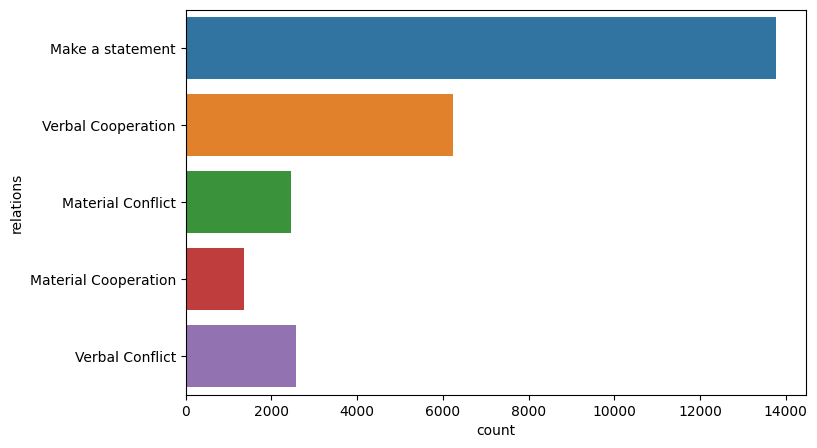

In [15]:
#enlargen dataframe so we have one row per relation instead of text with multiple relations
expl_penta = penta.explode("relations")
fig = plt.figure(figsize = (8,5))
sns.countplot(y = expl_penta.relations);
#generally more balanced than the CAMEO scores, but strongly focused on cooperation